## 计算两个TF activity的相关性
按照celltype进行平均，然后计算TF activity在不同celltype中的平均值的 两个向量的相关性，
Ⅰ 一个是Mmodel_Mother，一个是Mmodel_Hother
Ⅱ 一个是Mmodel_Mother,一个是Hmodel_Hother

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import scipy
import scipy.sparse as sparse

from scipy.stats   import pearsonr, spearmanr, kendalltau
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

In [2]:
fig_out = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/97_tfactivity/fig_out/'

In [3]:
# 两个AnnData对象 adata1 和 adata2
# 步骤1: 统一var为大写并提取共同基因
def process_adatas(adata1, adata2):
    # 复制对象避免修改原始数据
    adata1 = adata1.copy()
    adata2 = adata2.copy()
    
    # 统一var为大写
    adata1.var_names = [x.upper() for x in adata1.var_names]
    adata2.var_names = [x.upper() for x in adata2.var_names]
    
    # 获取共同基因
    common_genes = adata1.var_names.intersection(adata2.var_names)
    print(f"Found {len(common_genes)} common genes")
    
    # 子集化数据
    adata1_common = adata1[:, common_genes]
    adata2_common = adata2[:, common_genes]
    
    return adata1_common, adata2_common

# 步骤2: 计算细胞类型均值矩阵
def calculate_celltype_means(adata):
    # 创建表达矩阵的DataFrame
    expr_df = pd.DataFrame(
        adata.X.todense() if scipy.sparse.issparse(adata.X) else adata.X,
        index=adata.obs_names,
        columns=adata.var_names
    )
    
    # 添加细胞类型信息
    expr_df['cell_type'] = adata.obs['cell_type']
    
    # 按细胞类型分组计算均值
    mean_df = expr_df.groupby('cell_type').mean()
    return mean_df

# 步骤3: 计算基因相关性
def calculate_correlations(mean_df1, mean_df2):
    # 确保相同的细胞类型顺序
    common_celltypes = mean_df1.index.intersection(mean_df2.index)
    mean_df1 = mean_df1.loc[common_celltypes]
    mean_df2 = mean_df2.loc[common_celltypes]
    
    # 确保相同的基因顺序
    common_genes = mean_df1.columns.intersection(mean_df2.columns)
    mean_df1 = mean_df1[common_genes]
    mean_df2 = mean_df2[common_genes]
    
    # 计算每个基因的相关性
    correlations = []
    for gene in common_genes:
        r,_ = pearsonr(mean_df1[gene], mean_df2[gene])
        # r = cosine_similarity([mean_df1[gene]], [mean_df2[gene]])[0][0]
        correlations.append(r)
            # r,_ = pearsonr(mean_df1[gene], mean_df2[gene])
            # r,_ = spearmanr(mean_df1[gene], mean_df2[gene])
            # kendall = kendalltau(x, y)[0]
            # r = cosine_similarity([mean_df1[gene]], [mean_df2[gene]])[0][0]
            # euclid  = np.linalg.norm(x - y)
            # manhat  = np.abs(x - y).sum()
    return pd.Series(correlations, index=common_genes), common_celltypes

In [4]:
# 全局设置字体大小（影响所有文本元素）
plt.rcParams.update({
    'font.size': 15,               # 基础字体大小
    'axes.titlesize': 20,           # 坐标轴标题大小
    'axes.labelsize': 20,           # 坐标轴标签大小
    'xtick.labelsize': 15,           # X轴刻度标签大小
    'ytick.labelsize': 15,            # Y轴刻度标签大小
    'font.weight': 'normal',      # 文本元素全局加粗 normal/bold
    'axes.labelweight': 'normal', # 坐标轴标签加粗 normal/bold
    'axes.titleweight': 'normal'  # 标题加粗 normal/bold
})
# matplot 输出的图片为illustrator可编辑的字体
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# m1d1nModel_m1d1Other  &  m1d1nModel_Mother 跨样本和跨物种

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


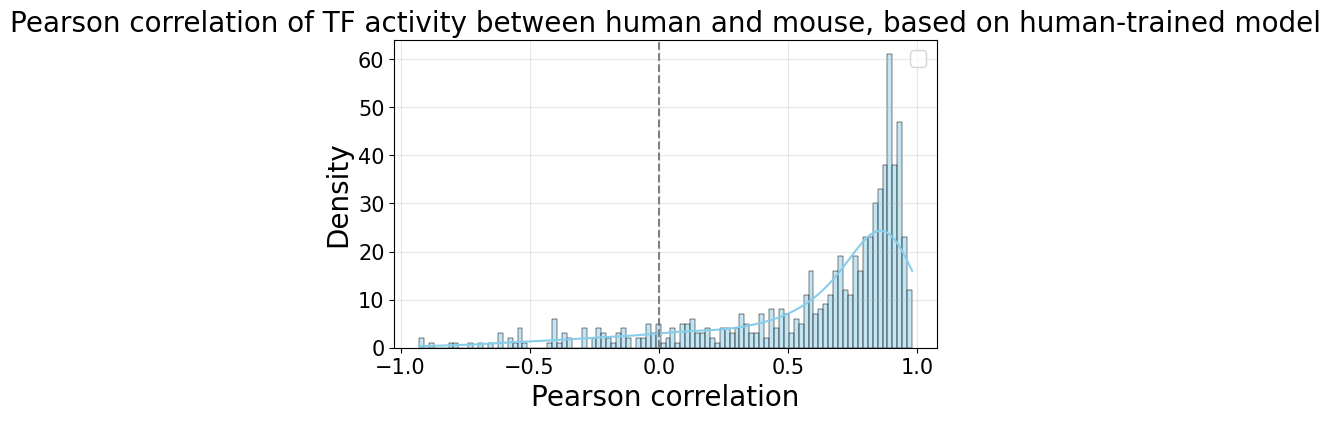

In [6]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hhact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_human/m1d1nModel_m1d1Other.h5ad')
hmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/m1d1nModel_Mother.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, hmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(7, 4))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
# plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
#             label=f'Mean: {correlation_series.values.flatten().mean():.2f}'
#            )
plt.axvline(x=0, color='grey', linestyle='--', 
            label=None
           )
plt.xlabel('Pearson correlation')
plt.ylabel('Density')
plt.title('Pearson correlation of TF activity between human and mouse, based on human-trained model')
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig(f'{fig_out}/m1d1nM_m1d1O-mouseO.pdf', bbox_inches='tight', dpi=300,format="pdf")
plt.show()

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


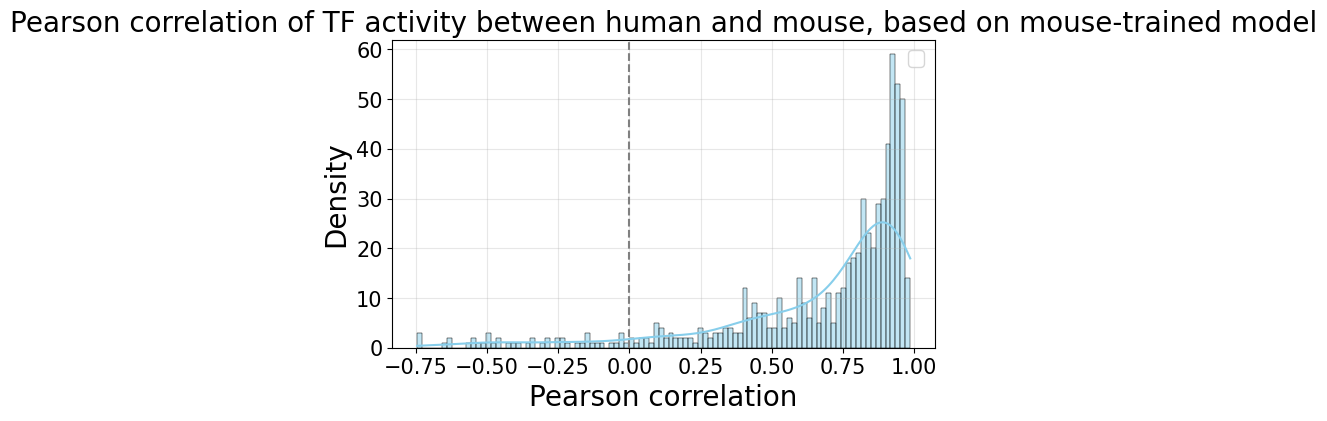

In [7]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
mhact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_human/Mmodel_m1d1Other.h5ad')
mmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/Mmodel_Mother.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(mhact, mmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(7, 4))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
# plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
#             label=f'Mean: {correlation_series.values.flatten().mean():.2f}'
#            )
plt.axvline(x=0, color='grey', linestyle='--', 
            label=None
           )
plt.xlabel('Pearson correlation')
plt.ylabel('Density')
plt.title('Pearson correlation of TF activity between human and mouse, based on mouse-trained model')
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig(f'{fig_out}/mM_m1d1O-mouseO.pdf', bbox_inches='tight', dpi=300,format="pdf")
plt.show()

# Mmodel_Mother  &  m1d1nModel_m1d1Other 本样本和本物种跨样本

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


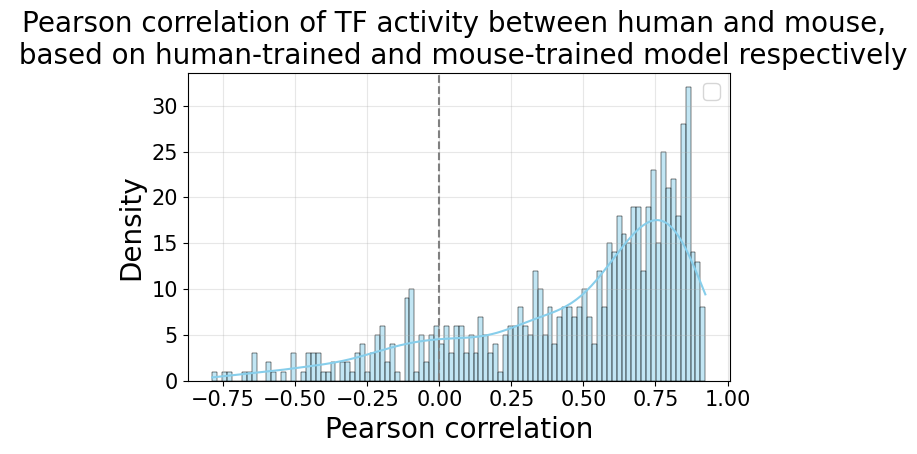

In [8]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hhact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_human/m1d1nModel_m1d1Other.h5ad')
mmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/Mmodel_Mother.h5ad')
# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, mmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(7, 4))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
# plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
#             label=f'Mean: {correlation_series.values.flatten().mean():.2f}'
#            )
plt.axvline(x=0, color='grey', linestyle='--', 
            label=None
           )
plt.xlabel('Pearson correlation')
plt.ylabel('Density')
plt.title('Pearson correlation of TF activity between human and mouse, \n based on human-trained and mouse-trained model respectively')
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig(f'{fig_out}/mM_m1d1nM-mO_m1d1O.pdf', bbox_inches='tight', dpi=300,format="pdf")
plt.show()

### 查看具体motif在human和mouse样本中的活性分布情况

In [5]:
fig_out

'/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/97_tfactivity/fig_out/'

In [326]:
# dnajc5_out = f'{fig_out}/dnajc5_motifActivity/'

In [9]:
mhact_rna = sc.read_h5ad(f'{path}/harmony_pca/m1d1_rna_harmony.h5ad')
mmact_rna = sc.read_h5ad(f'{path}/harmony_pca/mop3c2_rna_harmony.h5ad')

In [10]:
# 对 tf_act_raw 中的每个变量进行标准化处理
sc.pp.scale(mhact)
sc.pp.scale(mmact)

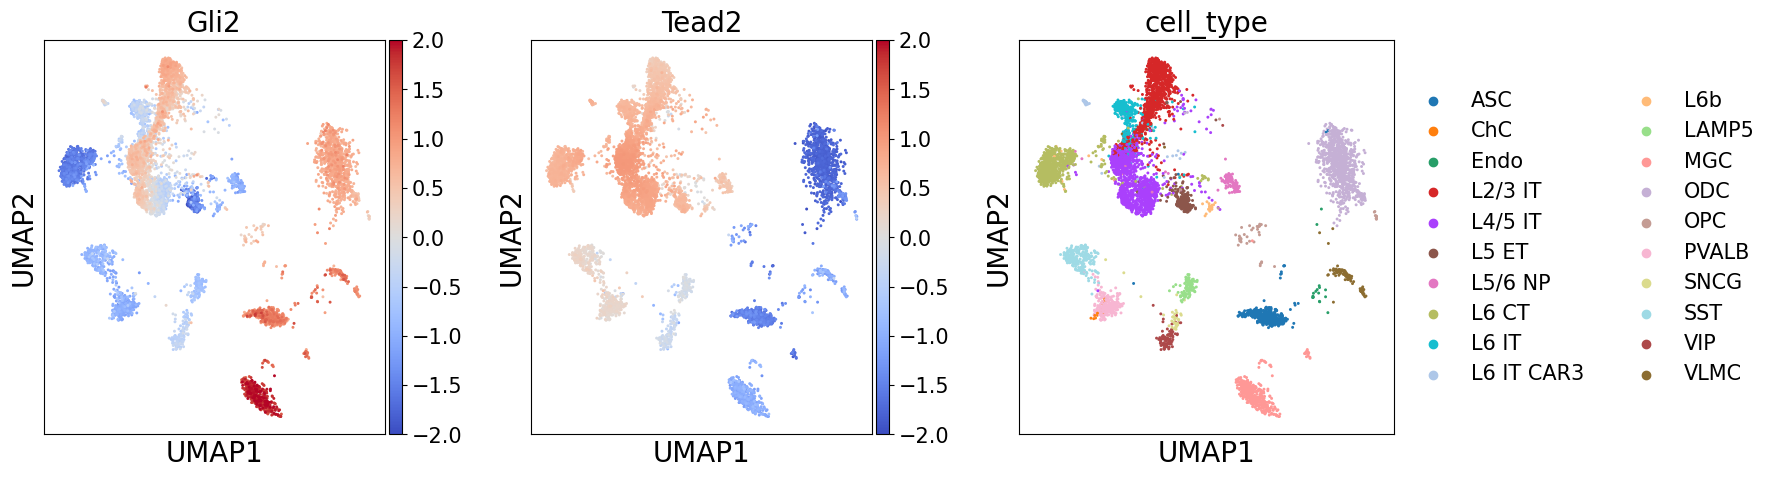

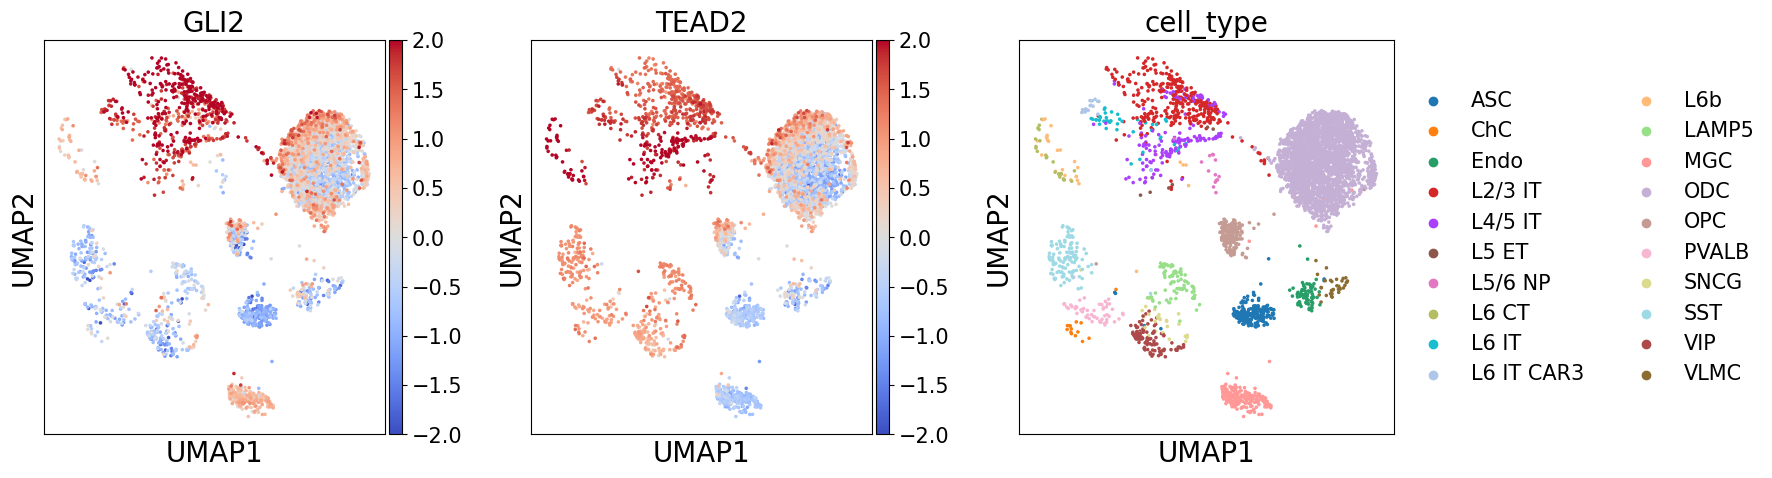

In [11]:
t1 = 'Gli2'
t2 = 'Tead2'
# t1 = 'Tead2'
# t2 = 'Gli2'
ad2 = mmact[:,mmact.var['motif_name']==t1]
mmact_rna.obs[t1] = ad2.X.flatten()  # 提取一维数组
ad2 = mmact[:,mmact.var['motif_name']==t2]
mmact_rna.obs[t2] = ad2.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mmact_rna, color=t1, ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mmact_rna, color=t2, ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mmact_rna, color='cell_type', ax=axs[2], show=False)
f.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)  # 自动调整间距
f.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # 手动微调
# 保存为PDF
# plt.savefig(f"{fig_out}/mModel_M_activityZ.pdf", format="pdf", bbox_inches="tight", dpi=300)
# plt.close()

ad1 = mhact[:,mhact.var['motif_name']==t1.upper()]
mhact_rna.obs[t1.upper()] = ad1.X.flatten()  # 提取一维数组
ad1 = mhact[:,mhact.var['motif_name']==t2.upper()]
mhact_rna.obs[t2.upper()] = ad1.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mhact_rna, color=t1.upper(), ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mhact_rna, color=t2.upper(), ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mhact_rna, color='cell_type', ax=axs[2], show=False)
f.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)  # 自动调整间距
f.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # 手动微调
# 保存为PDF
# plt.savefig(f"{fig_out}/mModel_H_activityZ.pdf", format="pdf", bbox_inches="tight", dpi=300)
# plt.close()

In [12]:
# 获取当前使用的完整调色板
if 'cell_type_colors' in mmact_rna.uns:
    current_colors = mmact_rna.uns['cell_type_colors']
    current_palette = dict(zip(mmact_rna.obs['cell_type'].cat.categories, current_colors))

In [13]:
mmact_rna.uns

{'batch_colors': array(['#17becf'], dtype=object),
 'cell_type_colors': array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
        '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
        '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d', '#9edae5',
        '#ad494a', '#8c6d31'], dtype=object),
 'hvg': {'flavor': 'seurat'},
 'log1p': {},
 'neighbors': {'connectivities_key': 'connectivities',
  'distances_key': 'distances',
  'params': {'method': 'umap',
   'metric': 'euclidean',
   'n_neighbors': 15,
   'random_state': 0,
   'use_rep': 'X_pca_harmony'}},
 'pca': {'params': {'use_highly_variable': True, 'zero_center': True},
  'variance': array([66.52787903, 34.09907985, 21.74600913, 18.4700239 , 15.35085595,
         12.24464942, 10.02417793,  7.6404829 ,  7.16189236,  6.70454813,
          5.7306096 ,  5.42748137,  5.13482114,  4.94727255,  4.2053965 ,
          3.95928216,  3.7472935 ,  3.51687538,  2.99815458,  2.93435304,
          2.73011

In [18]:
current_palette

{'ASC': '#1f77b4',
 'ChC': '#ff7f0e',
 'Endo': '#279e68',
 'L2/3 IT': '#d62728',
 'L4/5 IT': '#aa40fc',
 'L5 ET': '#8c564b',
 'L5/6 NP': '#e377c2',
 'L6 CT': '#b5bd61',
 'L6 IT': '#17becf',
 'L6 IT CAR3': '#aec7e8',
 'L6b': '#ffbb78',
 'LAMP5': '#98df8a',
 'MGC': '#ff9896',
 'ODC': '#c5b0d5',
 'OPC': '#c49c94',
 'PVALB': '#f7b6d2',
 'SNCG': '#dbdb8d',
 'SST': '#9edae5',
 'VIP': '#ad494a',
 'VLMC': '#8c6d31'}

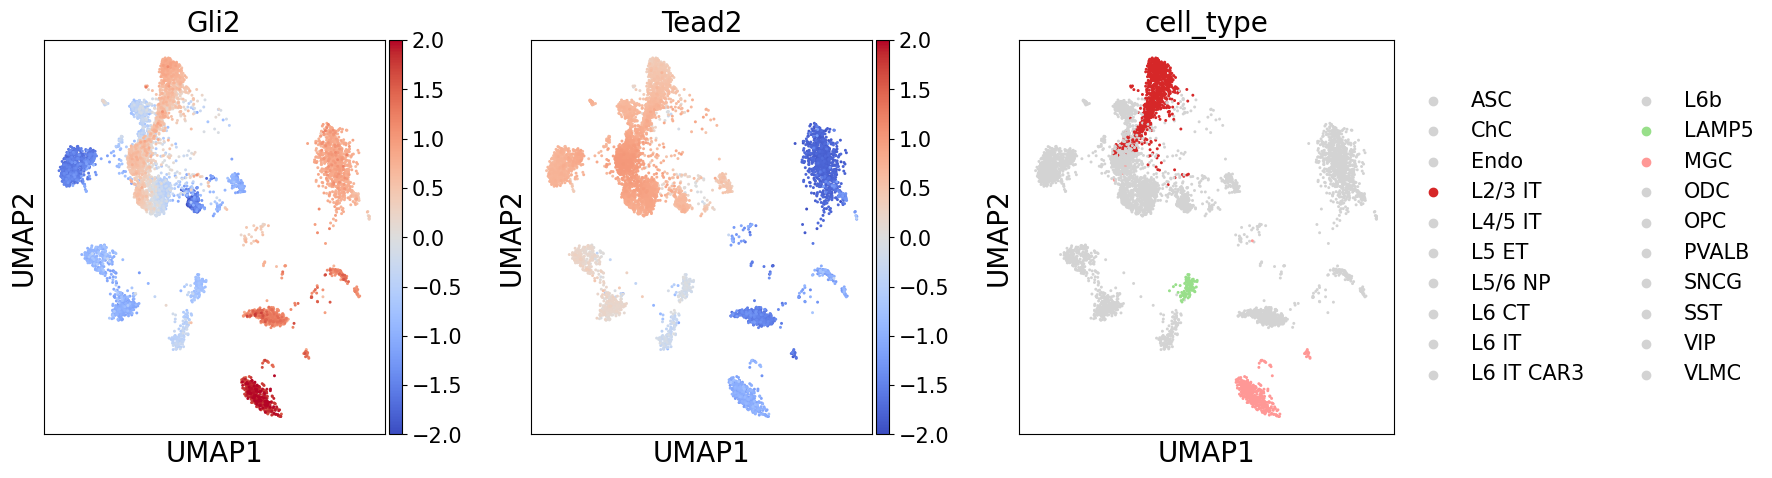

In [19]:
ad2 = mmact[:,mmact.var['motif_name']==t1]
mmact_rna.obs[t1] = ad2.X.flatten()  # 提取一维数组
ad2 = mmact[:,mmact.var['motif_name']==t2]
mmact_rna.obs[t2] = ad2.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mmact_rna, color=t1, ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mmact_rna, color=t2, ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
# 获取所有细胞类型
cell_types = mmact_rna.obs['cell_type'].unique()
# 创建一个新的颜色映射：保留当前颜色，非目标类型设为灰色
new_palette = {}
for i, ct in enumerate(cell_types):
    if ct in ['L2/3 IT', 'LAMP5', 'MGC']:
        # 保留当前颜色（循环使用默认调色板）
        new_palette[ct] = current_palette[ct]
    else:
        # 非目标类型设为灰色
        new_palette[ct] = '#d3d3d3'  # 浅灰色

# 第三个子图使用自定义颜色映射
sc.pl.umap(mmact_rna, color='cell_type', ax=axs[2], palette=new_palette, show=False)

# 调整布局并保存
f.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)
f.subplots_adjust(left=0.05, right=0.95, wspace=0.3)

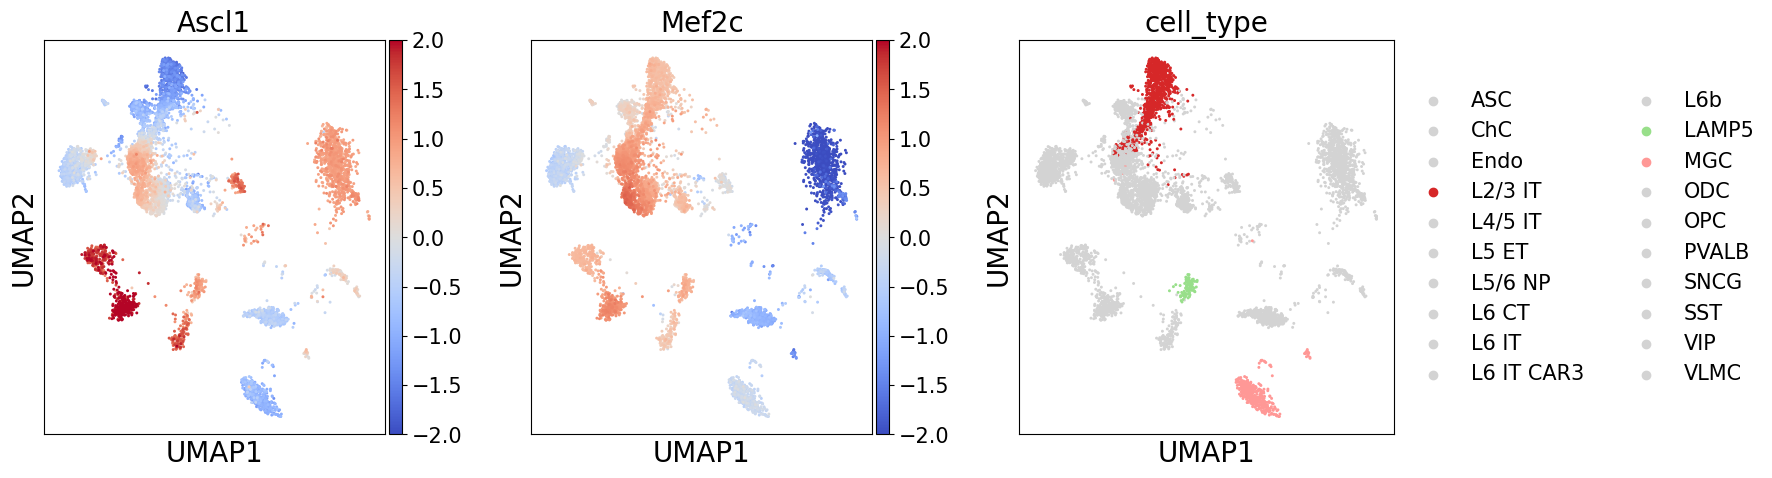

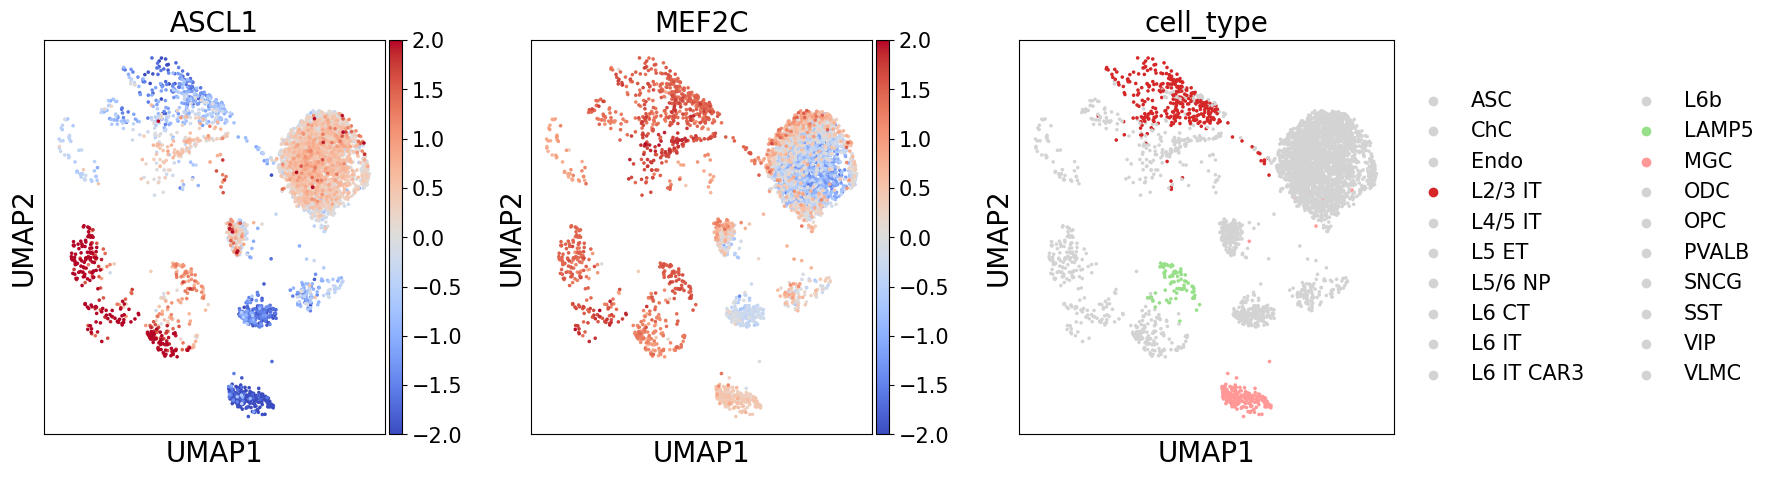

In [21]:
t1 = 'Ascl1'
t2 = 'Mef2c'
# t1 = 'Tead2'
# t2 = 'Gli2'
ad2 = mmact[:,mmact.var['motif_name']==t1]
mmact_rna.obs[t1] = ad2.X.flatten()  # 提取一维数组
ad2 = mmact[:,mmact.var['motif_name']==t2]
mmact_rna.obs[t2] = ad2.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mmact_rna, color=t1, ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mmact_rna, color=t2, ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
# 获取所有细胞类型
cell_types = mmact_rna.obs['cell_type'].unique()
# 创建一个新的颜色映射：保留当前颜色，非目标类型设为灰色
new_palette = {}
for i, ct in enumerate(cell_types):
    if ct in ['L2/3 IT', 'LAMP5', 'MGC']:
        # 保留当前颜色（循环使用默认调色板）
        new_palette[ct] = current_palette[ct]
    else:
        # 非目标类型设为灰色
        new_palette[ct] = '#d3d3d3'  # 浅灰色
# 第三个子图使用自定义颜色映射
sc.pl.umap(mmact_rna, color='cell_type', ax=axs[2], palette=new_palette, show=False)
f.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)  # 自动调整间距
f.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # 手动微调
# 保存为PDF
plt.savefig(f"{fig_out}/mModel_M_activityZ1.pdf", format="pdf", bbox_inches="tight", dpi=300)
# plt.close()

ad1 = mhact[:,mhact.var['motif_name']==t1.upper()]
mhact_rna.obs[t1.upper()] = ad1.X.flatten()  # 提取一维数组
ad1 = mhact[:,mhact.var['motif_name']==t2.upper()]
mhact_rna.obs[t2.upper()] = ad1.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mhact_rna, color=t1.upper(), ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mhact_rna, color=t2.upper(), ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
# 获取所有细胞类型
cell_types = mhact_rna.obs['cell_type'].unique()
# 创建一个新的颜色映射：保留当前颜色，非目标类型设为灰色
new_palette = {}
for i, ct in enumerate(cell_types):
    if ct in ['L2/3 IT', 'LAMP5', 'MGC']:
        # 保留当前颜色（循环使用默认调色板）
        new_palette[ct] = current_palette[ct]
    else:
        # 非目标类型设为灰色
        new_palette[ct] = '#d3d3d3'  # 浅灰色
# 第三个子图使用自定义颜色映射
sc.pl.umap(mhact_rna, color='cell_type', ax=axs[2], palette=new_palette, show=False)

f.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)  # 自动调整间距
f.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # 手动微调
# 保存为PDF
plt.savefig(f"{fig_out}/mModel_H_activityZ1.pdf", format="pdf", bbox_inches="tight", dpi=300)
# plt.close()

In [330]:
# 对 tf_act_raw 中的每个变量进行标准化处理
sc.pp.scale(hhact)
sc.pp.scale(hmact)

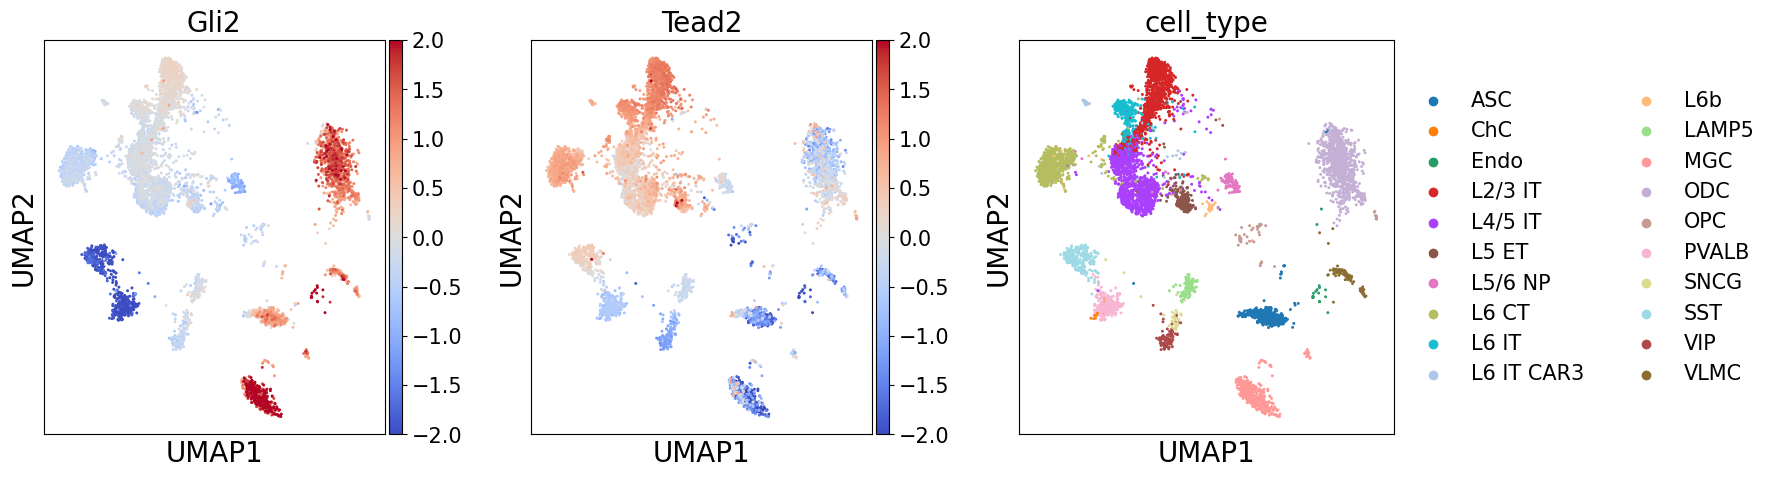

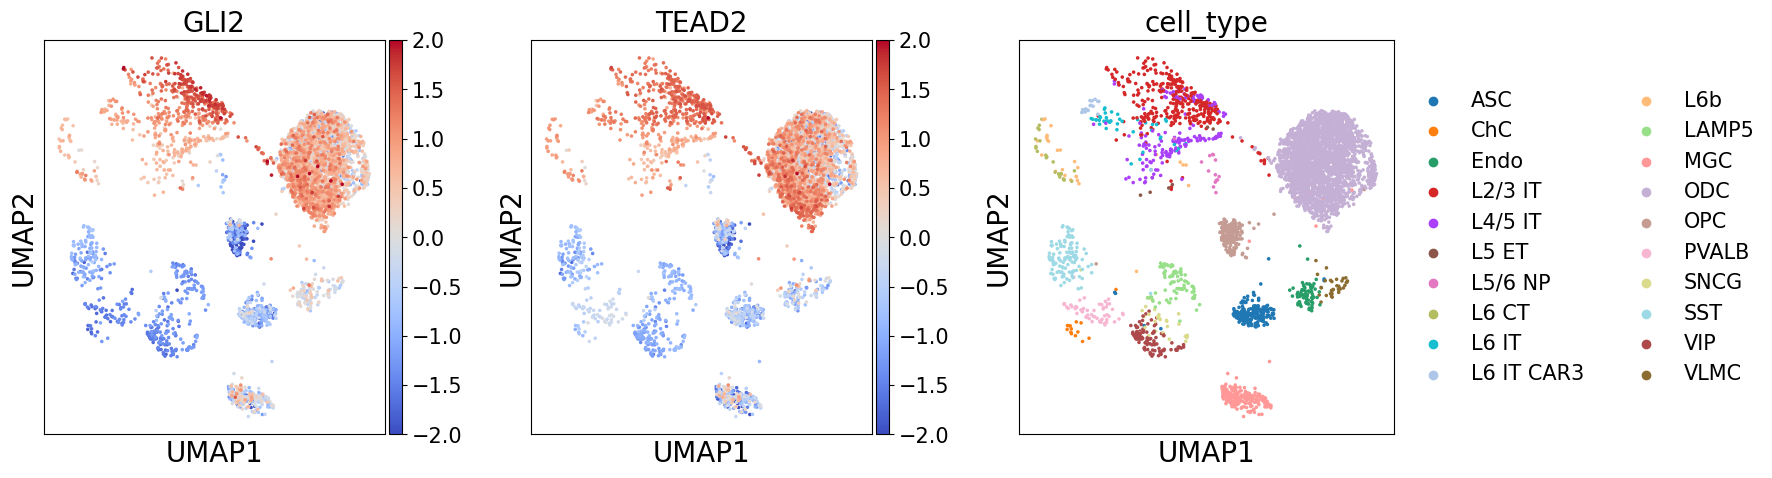

In [331]:
t1 = 'Gli2'
t2 = 'Tead2'

ad2 = hmact[:,hmact.var['motif_name']==t1]
mmact_rna.obs[t1] = ad2.X.flatten()  # 提取一维数组
ad2 = hmact[:,hmact.var['motif_name']==t2]
mmact_rna.obs[t2] = ad2.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mmact_rna, color=t1, ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mmact_rna, color=t2, ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mmact_rna, color='cell_type', ax=axs[2], show=False)
f.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)  # 自动调整间距
f.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # 手动微调
# 保存为PDF
plt.savefig(f"{dnajc5_out}/hModel_M_activityZ.pdf", format="pdf", bbox_inches="tight", dpi=300)
# plt.close()

ad1 = hhact[:,hhact.var['motif_name']==t1.upper()]
mhact_rna.obs[t1.upper()] = ad1.X.flatten()  # 提取一维数组
ad1 = hhact[:,hhact.var['motif_name']==t2.upper()]
mhact_rna.obs[t2.upper()] = ad1.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mhact_rna, color=t1.upper(), ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mhact_rna, color=t2.upper(), ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mhact_rna, color='cell_type', ax=axs[2], show=False)
f.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)  # 自动调整间距
f.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # 手动微调
# 保存为PDF
plt.savefig(f"{dnajc5_out}/hModel_H_activityZ.pdf", format="pdf", bbox_inches="tight", dpi=300)
# plt.close()

# 下面是所有的测试结果

## Ⅰ Mmodel_Mother  &  Mmodel_m1d1Other  本物种和跨物种1

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


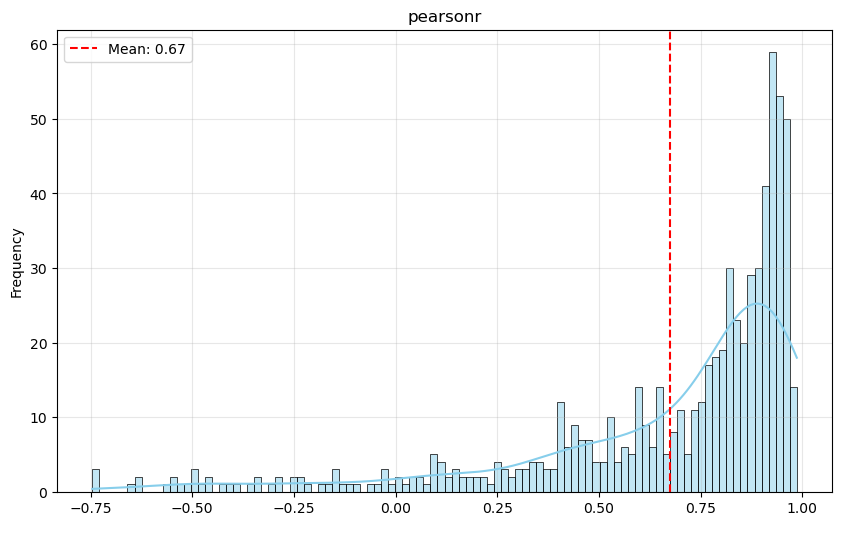

In [269]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
mhact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_human/Mmodel_m1d1Other.h5ad')
mmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/Mmodel_Mother.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(mhact, mmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [181]:
len(correlation_series[correlation_series<0])

45

In [182]:
correlation_series[:20]

ALX1      0.814842
ALX3      0.396766
ALX4      0.816478
AR        0.861152
ARID3A    0.912657
ARID3B    0.799247
ARID5A    0.881358
ARID5B    0.919329
ARNT      0.860347
ARNT2     0.167459
ARNTL     0.597098
ARX       0.888948
ASCL1     0.916257
ASCL2     0.925614
ATF1      0.438342
ATF2      0.694343
ATF3      0.463734
ATF4      0.444228
ATF6      0.781704
ATF6B     0.539597
dtype: float64

In [183]:
correlation_series.nlargest(10)

HSF5      0.986299
TRPS1     0.984280
TFAP2B    0.975792
SPI1      0.975438
SOX13     0.975063
RARA      0.974835
SOX2      0.974540
IRF8      0.972456
TBX1      0.971479
NR1I2     0.971264
dtype: float64

In [184]:
correlation_series.nsmallest(10)

HOXA2    -0.745733
BCL6     -0.743763
FOXO3    -0.742876
NR2E3    -0.654385
VSX2     -0.640798
HOXB2    -0.631322
TCF7L1   -0.556670
HNF1B    -0.538967
KLF4     -0.538151
TBX2     -0.535200
dtype: float64

## Ⅰ Ⅱ Mmodel_Mother  &  Mmodel_m1d1nOther  本物种和跨物种2

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


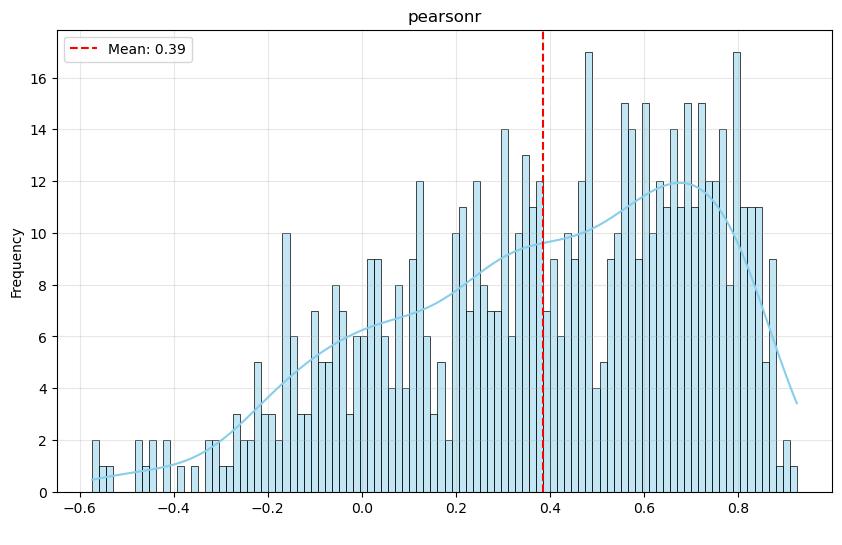

In [279]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
mhact = sc.read_h5ad(f'{path}/97_tfactivity/predOn_m1d1n/activity_out_human/Mmodel_m1d1nOther.h5ad')
mmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/Mmodel_Mother.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, mmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


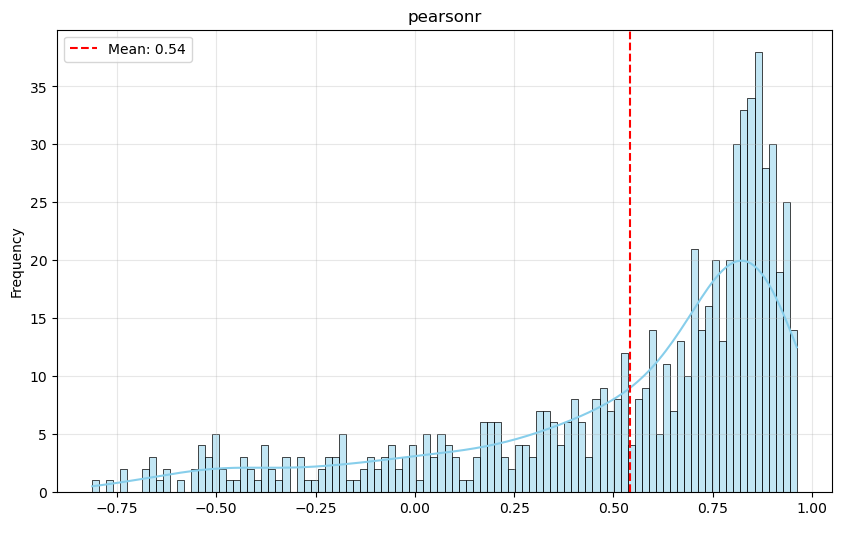

In [280]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hhact = sc.read_h5ad(f'{path}/97_tfactivity/trainOn_m1d1/activity_out_human/m1d1Model_m1d1nOther.h5ad')
mmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/m1d1Model_Mother.h5ad')
# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, mmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Found 1065 common genes
Calculated correlations for 1065 genes
Based on 20 common cell types


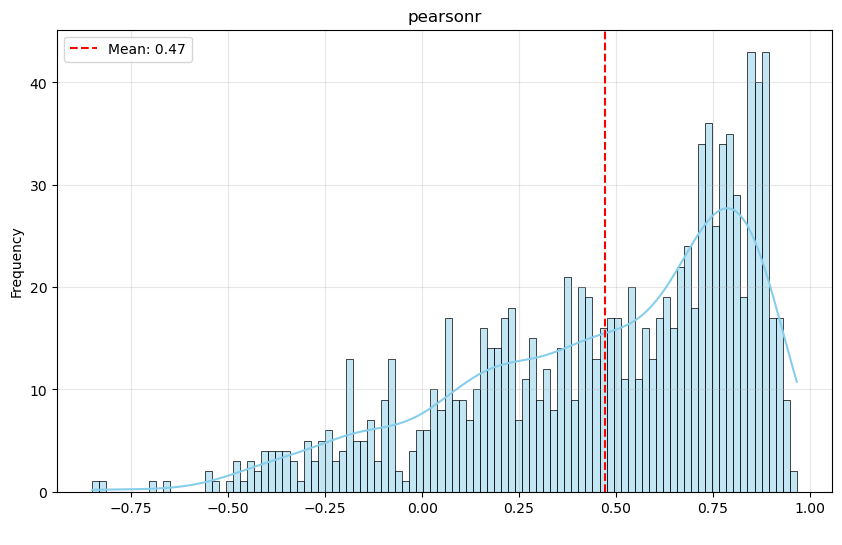

In [281]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
mhact = sc.read_h5ad(f'{path}/97_tfactivity/predOn_m1d1n/activity_out_human/Mmodel_m1d1nOther.h5ad')
mmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_human/Mmodel_m1d1Other.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, mmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Ⅱ Mmodel_Mother  &  m1d1nModel_m1d1Other

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


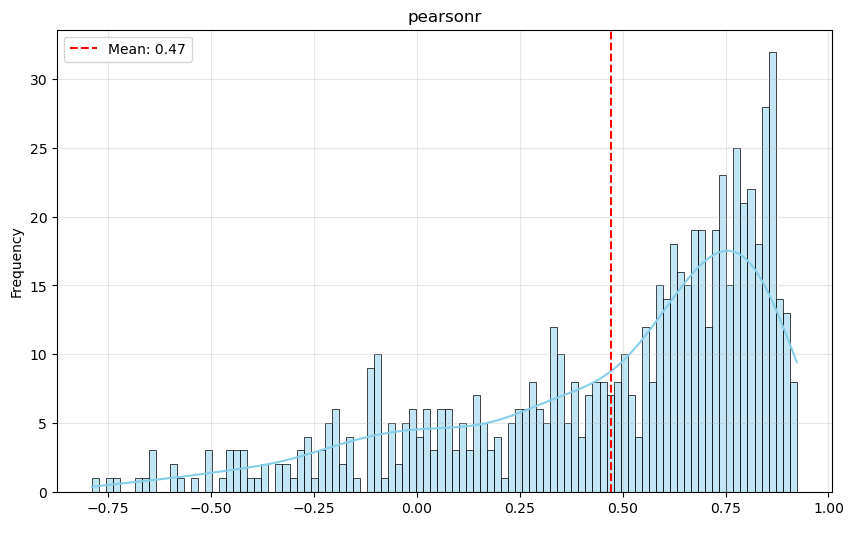

In [265]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hhact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_human/m1d1nModel_m1d1Other.h5ad')
mmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/Mmodel_Mother.h5ad')
# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, mmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [171]:
correlation_series.nlargest(10)

HOXB1    0.809665
PPARG    0.807058
EMX2     0.787532
EVX1     0.774772
ESX1     0.769515
HOXD4    0.752241
EMX1     0.751401
HOXA1    0.749722
LHX9     0.730138
VSX1     0.727933
dtype: float64

In [172]:
correlation_series.nsmallest(10)

NFE2L1   -0.768457
FOSL1    -0.674141
TEAD1    -0.655792
SCRT2    -0.643954
HSF5     -0.641623
T        -0.635417
CREBZF   -0.628119
NAIF1    -0.610018
ARNT2    -0.609638
FOS      -0.603970
dtype: float64

In [173]:
len(correlation_series[correlation_series<0])

310

In [174]:
# 对 tf_act_raw 中的每个变量进行标准化处理
sc.pp.scale(hhact)
sc.pp.scale(mmact)

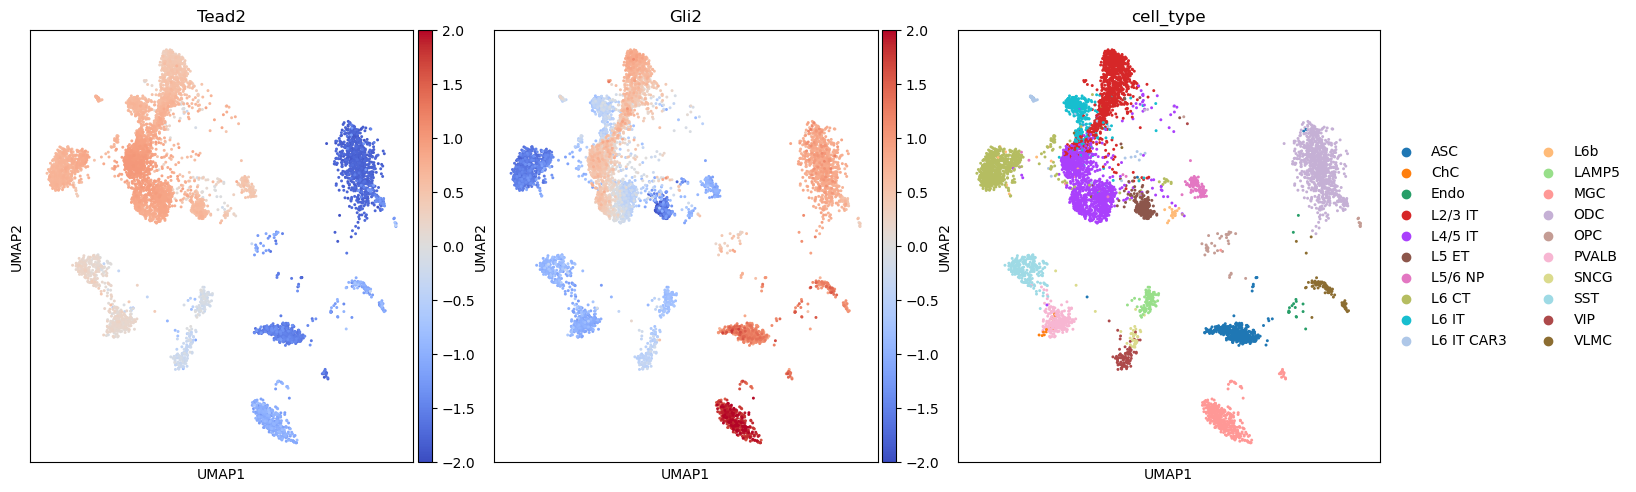

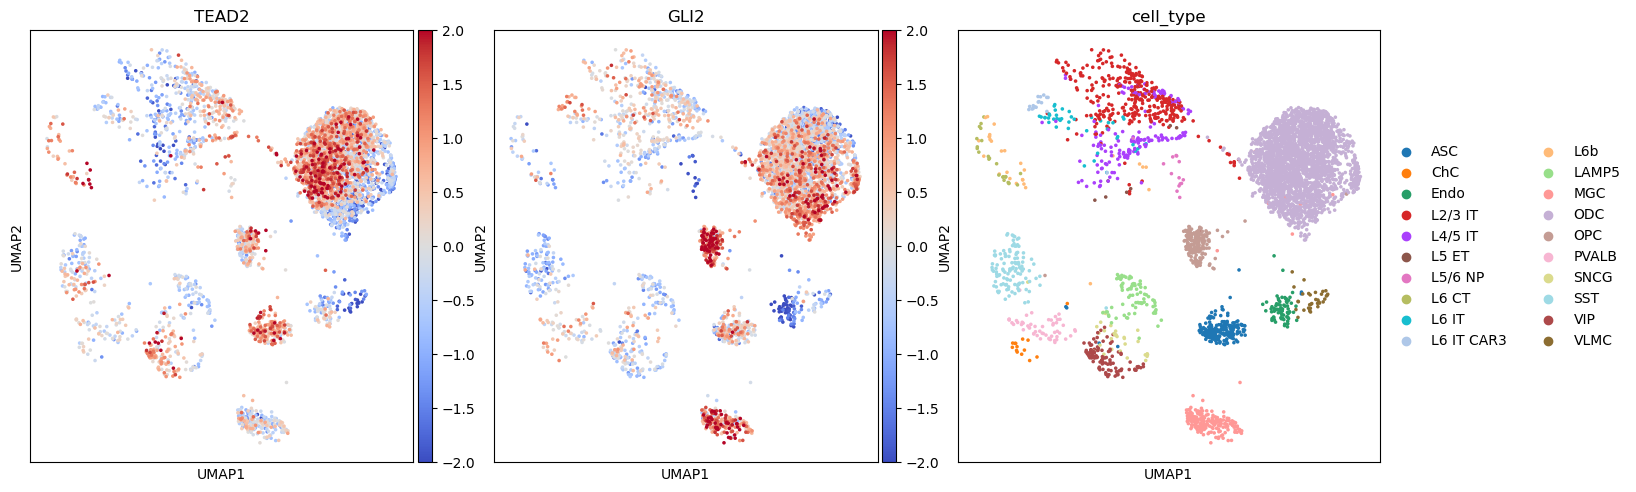

In [176]:
# t1 = 'Nfe2l1'
# t2 = 'Fosl1'
# t1 = 'Ascl1'
# t2 = 'Mef2c'
t1 = 'Tead2'
t2 = 'Gli2'
ad2 = mmact[:,mmact.var['motif_name']==t1]
mmact_rna.obs[t1] = ad2.X.flatten()  # 提取一维数组
ad2 = mmact[:,mmact.var['motif_name']==t2]
mmact_rna.obs[t2] = ad2.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mmact_rna, color=t1, ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mmact_rna, color=t2, ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mmact_rna, color='cell_type', ax=axs[2], show=False)
f.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)  # 自动调整间距
f.subplots_adjust(left=0.05, right=0.95, wspace=0.1)  # 手动微调
# 保存为PDF
# plt.savefig(f"{out_dir}/cellmarker_activityZ.pdf", format="pdf", bbox_inches="tight", dpi=300)
# plt.close()

ad1 = hhact[:,hhact.var['motif_name']==t1.upper()]
mhact_rna.obs[t1.upper()] = ad1.X.flatten()  # 提取一维数组
ad1 = hhact[:,hhact.var['motif_name']==t2.upper()]
mhact_rna.obs[t2.upper()] = ad1.X.flatten()  # 提取一维数组
f, axs = plt.subplots(ncols=3, figsize=(15, 5))
sc.pl.umap(mhact_rna, color=t1.upper(), ax=axs[0], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mhact_rna, color=t2.upper(), ax=axs[1], cmap='coolwarm', vmin=-2, vmax=2,show=False)
sc.pl.umap(mhact_rna, color='cell_type', ax=axs[2], show=False)
f.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)  # 自动调整间距
f.subplots_adjust(left=0.05, right=0.95, wspace=0.1)  # 手动微调
# 保存为PDF
# plt.savefig(f"{out_dir}/cellmarker_activityZ.pdf", format="pdf", bbox_inches="tight", dpi=300)
# plt.close()

## ⅡⅠ Mmodel_Mother  &  m1d1nModel_m1d1nOther

In [262]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hhact = sc.read_h5ad(f'{path}/97_tfactivity/predOn_m1d1n/activity_out_human/m1d1nModel_m1d1nOther.h5ad')
mmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/Mmodel_Mother.h5ad')

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


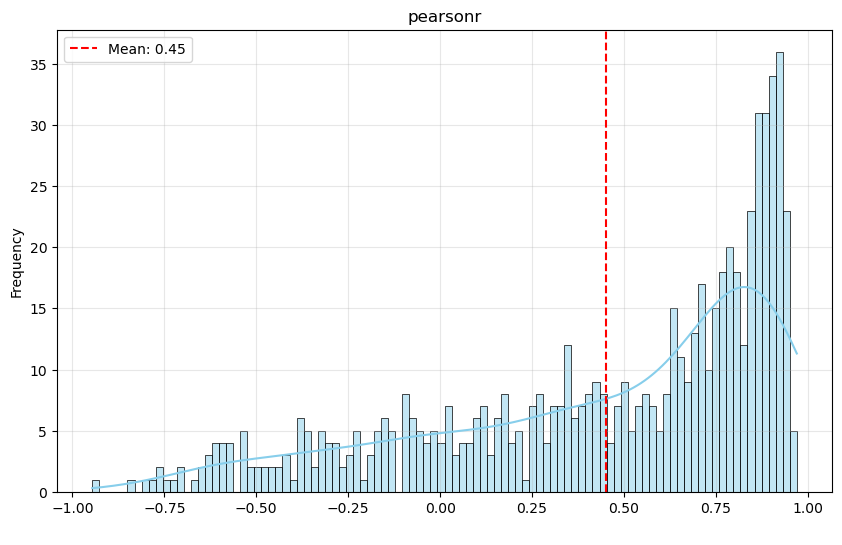

In [263]:
# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, mmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Ⅲ human model下，human和mouse的相关性
## m1d1nModel_Mother  &  m1d1nModel_m1d1Other

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


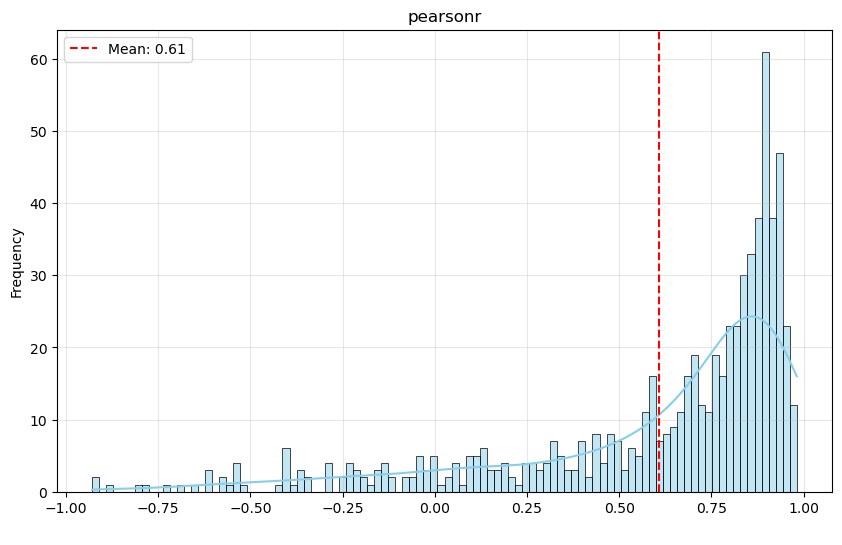

In [261]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hhact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_human/m1d1nModel_m1d1Other.h5ad')
hmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/m1d1nModel_Mother.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, hmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Ⅲ Ⅱ m1d1nModel & m1dnOther
## 如果是human 预测  m1d1n的  这个训练数据呢？？？？看下human model预测不同human样本的情况

In [270]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hhact = sc.read_h5ad(f'{path}/97_tfactivity/predOn_m1d1n/activity_out_human/m1d1nModel_m1d1nOther.h5ad')
hmact = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/m1d1nModel_Mother.h5ad')

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


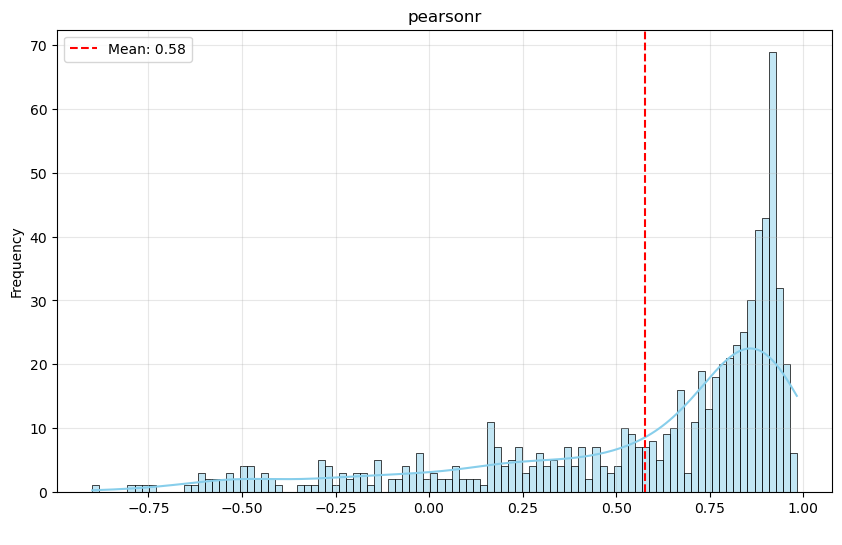

In [271]:
# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hhact, hmact)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Ⅳ m1d1Model & m1d1Other   vs   m1d1nModel & m1d1nOther
## 这样会和m1d1nModel & m1d1nOther 的结果一致性很高吗
## 表征两模型在预测各自训练数据上的性能，两个模型的表现是否相同

Found 1065 common genes
Calculated correlations for 1065 genes
Based on 20 common cell types


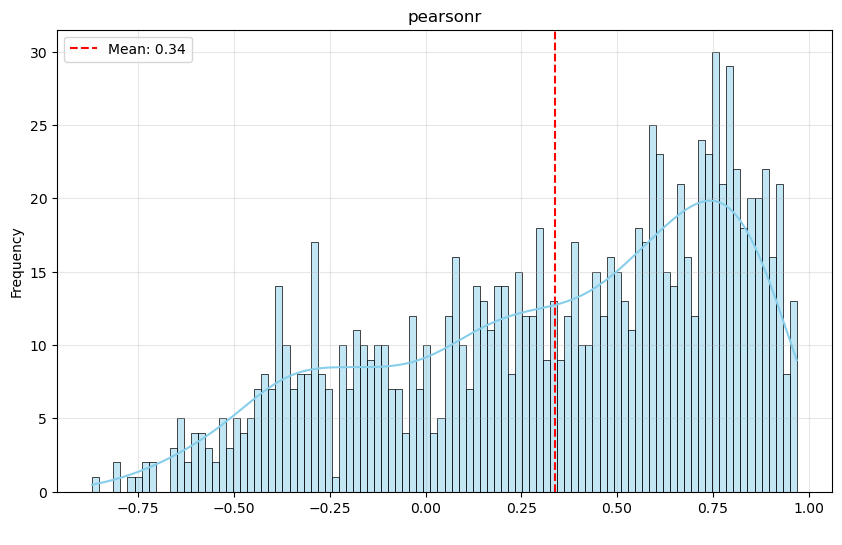

In [273]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hh1 = sc.read_h5ad(f'{path}/97_tfactivity/predOn_m1d1n/activity_out_human/m1d1nModel_m1d1nOther.h5ad')
hh2 = sc.read_h5ad(f'{path}/97_tfactivity/trainOn_m1d1/activity_out_human/m1d1Model_m1d1Other.h5ad')
# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hh1, hh2)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Ⅳ m1d1Model & m1d1Other    vs.    m1d1Model & m1d1nOther
## 差别大吗，表征两个模型在跨样本预测上的一致性

Found 1065 common genes
Calculated correlations for 1065 genes
Based on 20 common cell types


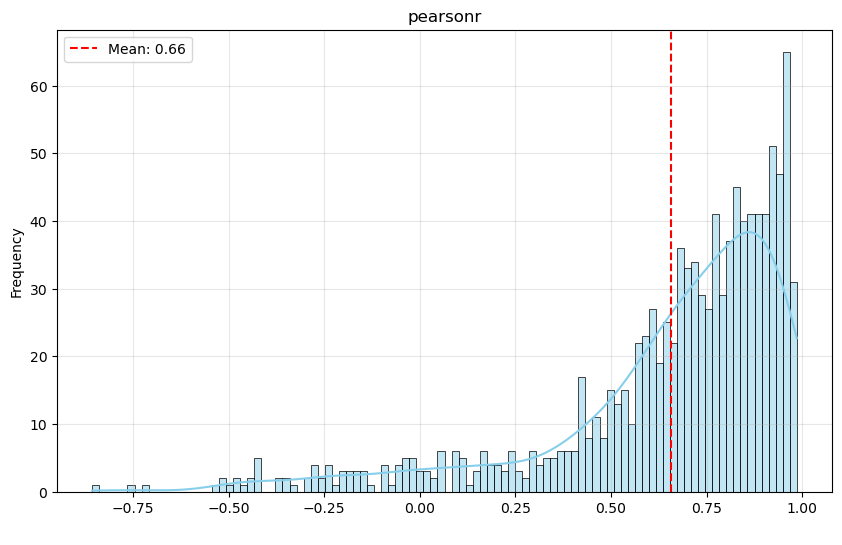

In [274]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hh1 = sc.read_h5ad(f'{path}/97_tfactivity/trainOn_m1d1/activity_out_human/m1d1Model_m1d1Other.h5ad')
hh2 = sc.read_h5ad(f'{path}/97_tfactivity/trainOn_m1d1/activity_out_human/m1d1Model_m1d1nOther.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hh1, hh2)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Found 1065 common genes
Calculated correlations for 1065 genes
Based on 20 common cell types


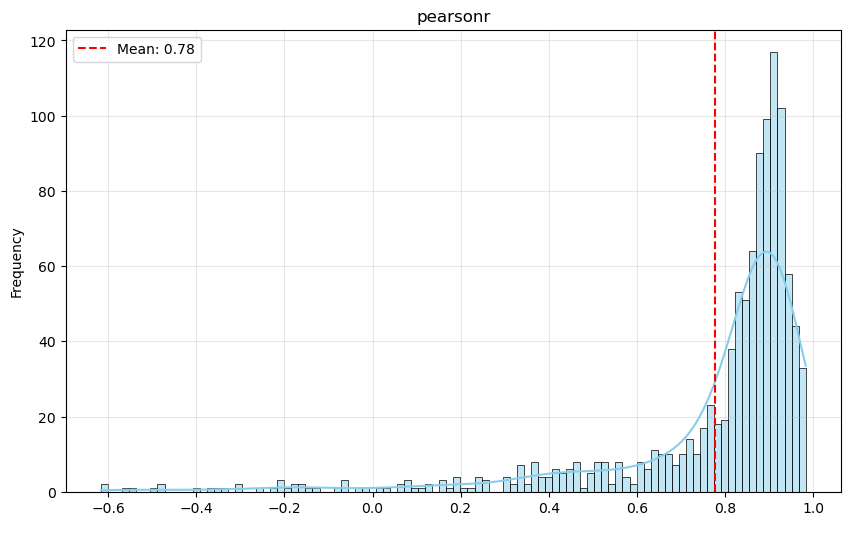

In [275]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hh1 = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_human/m1d1nModel_m1d1Other.h5ad')
hh2 = sc.read_h5ad(f'{path}/97_tfactivity/predOn_m1d1n/activity_out_human/m1d1nModel_m1d1nOther.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hh1, hh2)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


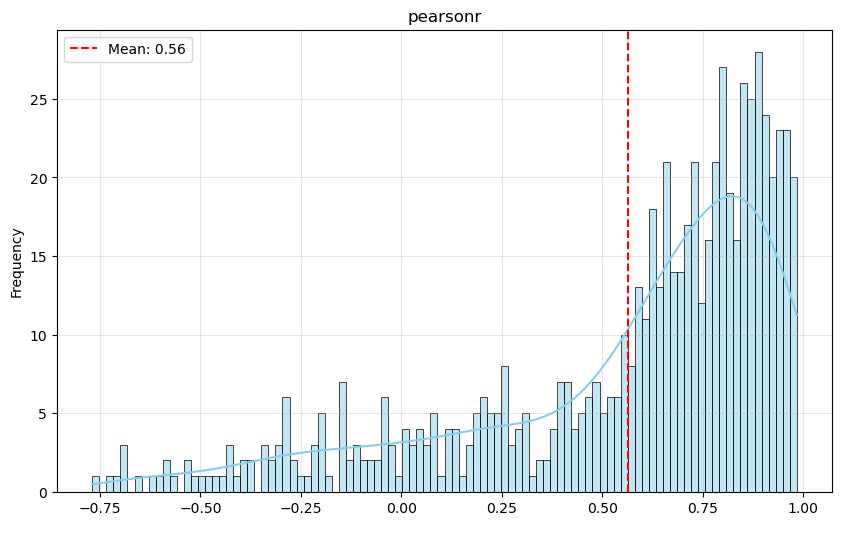

In [276]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hh1 = sc.read_h5ad(f'{path}/97_tfactivity/trainOn_m1d1/activity_out_human/m1d1Model_m1d1Other.h5ad')
hh2 = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/m1d1Model_Mother.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hh1, hh2)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hh1 = sc.read_h5ad(f'{path}/97_tfactivity/predOn_m1d1n/activity_out_human/Mmodel_m1d1nOther.h5ad')
hh2 = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/Mmodel_Mother.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hh1, hh2)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Found 677 common genes
Calculated correlations for 677 genes
Based on 20 common cell types


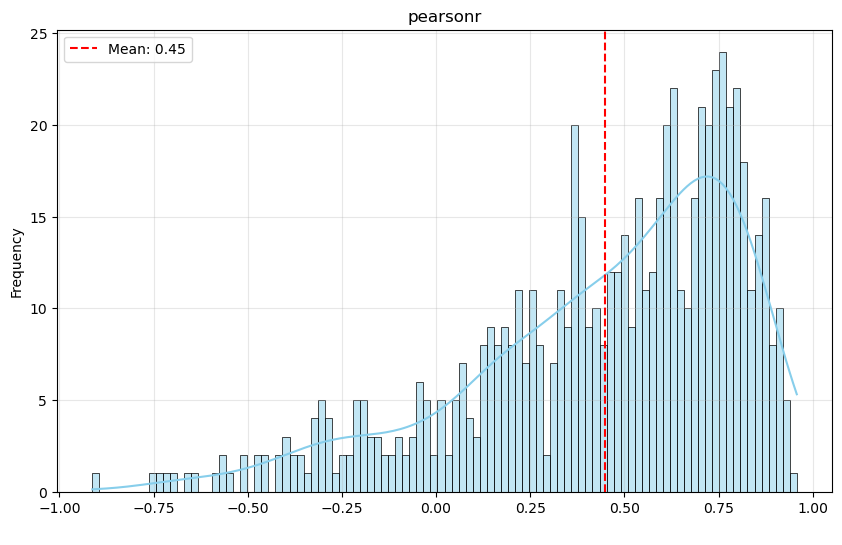

In [278]:
path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/2_human_NoDheni_n/'
hh1 = sc.read_h5ad(f'{path}/97_tfactivity/trainOn_m1d1/activity_out_human/m1d1Model_m1d1Other.h5ad')
hh2 = sc.read_h5ad(f'{path}/97_tfactivity/activity_out_mouse/Mmodel_Mother.h5ad')

# 1. 处理数据并提取共同基因
adata1_common, adata2_common = process_adatas(hh1, hh2)

# 2. 计算细胞类型均值矩阵
mean_df1 = calculate_celltype_means(adata1_common)
mean_df2 = calculate_celltype_means(adata2_common)

# 3. 计算基因相关性
correlation_series, common_celltypes = calculate_correlations(mean_df1, mean_df2)

print(f"Calculated correlations for {len(correlation_series)} genes")
print(f"Based on {len(common_celltypes)} common cell types")

# 4. 绘制相关性分布
plt.figure(figsize=(10, 6))
sns.histplot(correlation_series.values.flatten(), bins=100, kde=True, color='skyblue')
plt.axvline(x=correlation_series.values.flatten().mean(), color='red', linestyle='--', 
            label=f'Mean: {correlation_series.values.flatten().mean():.2f}')
plt.xlabel(' ')
plt.ylabel('Frequency')
plt.title('pearsonr')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## TF rna 表达

In [246]:
# path = '/picb/bigdata/project/miaoyuanyuan/train/single_cell/20.species4/'
# hrna = sc.read_h5ad(f'{path}/filt_data/1_human/m1d1/ad_rna.h5ad')
hrna2 = sc.read_h5ad(f'{path}/filt_data/1_human/m1d2n/ad_rna.h5ad')

In [247]:
hrna2

AnnData object with n_obs × n_vars = 8283 × 12770
    obs: 'cell_type', 'n_genes'
    var: 'ids', 'names', 'feature_types', 'chr', 'start', 'end', 'n_cells'

In [248]:
rna = hrna2.copy()
gene = 'ASCL1'
rna[:,rna.var['names']==gene]

View of AnnData object with n_obs × n_vars = 8283 × 1
    obs: 'cell_type', 'n_genes'
    var: 'ids', 'names', 'feature_types', 'chr', 'start', 'end', 'n_cells'

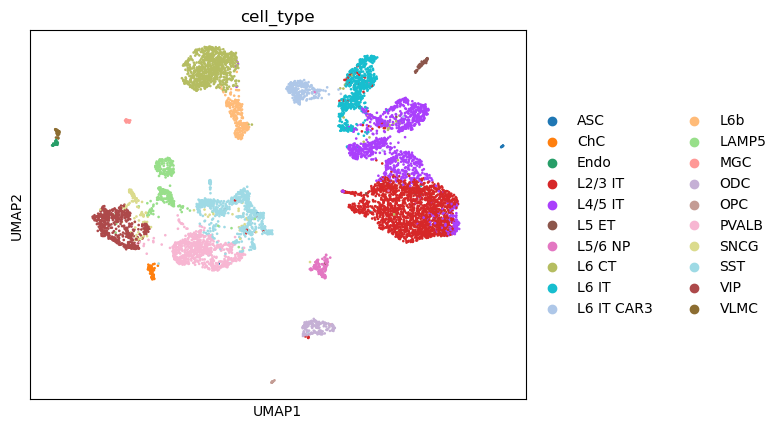

In [249]:
rna = hrna2.copy()
# Normalizing to median total counts
sc.pp.normalize_total(rna)
# Logarithmize the data
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna)
sc.pp.scale(rna, max_value=10)
sc.tl.pca(rna)
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.pl.umap(rna,color="cell_type")

In [250]:
# # rna.var[1480:1490]

# 	ids	names	feature_types	chr	start	end	n_cells	highly_variable	means	dispersions	dispersions_norm	mean	std
# 4230	ENSG00000237737	ASB8	Gene Expression	chr2	74385473	74385693	821	False	0.064426	0.366203	-0.515853	0.043756	0.173864
# 4231	ENSG00000284308	ASCC1	Gene Expression	chr2	74416582	74421560	648	False	0.051957	0.490727	-0.059542	0.034568	0.157088
# 4233	ENSG00000005448	ASCC2	Gene Expression	chr2	74421728	74421730	2027	False	0.172312	0.418706	-0.323459	0.119024	0.284262
# 4235	ENSG00000115274	ASCC3	Gene Expression	chr2	74455086	74455102	1254	False	0.099357	0.351212	-0.570787	0.068555	0.214570
# 4236	ENSG00000239779	ASF1A	Gene Expression	chr2	74458399	74458469	1505	True	0.135991	0.716149	0.766502	0.088338	0.257857
# 4237	ENSG00000115275	ASGR1	Gene Expression	chr2	74465361	74465410	1480	False	0.121778	0.511043	0.014903	0.082858	0.238829
# 4238	ENSG00000286883	ASH1L	Gene Expression	chr2	74465338	74465339	687	False	0.055062	0.380015	-0.465240	0.037298	0.161212
# 4245	ENSG00000115289	ASH2L	Gene Expression	chr2	74507694	74507695	899	False	0.067009	0.297268	-0.768462	0.046397	0.175068
# 4248	ENSG00000115307	ASIC1	Gene Expression	chr2	74529705	74529706	2647	False	0.241734	0.465085	-0.153506	0.167346	0.338989
# 4249	ENSG00000115317	ASIC2	Gene Expression	chr2	74529376	74529990	1491	False	0.121438	0.338987	-0.615584	0.083728	0.23848

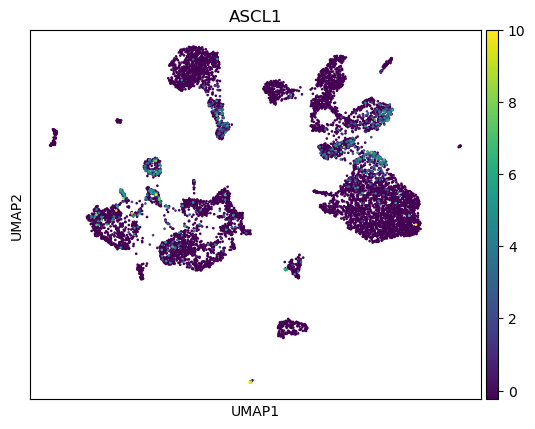

In [251]:
gene = 'ASCL1'
m1ad = rna[:,rna.var['names']==gene]
rna.obs[gene] = m1ad.X.flatten()  # 提取一维数组
sc.pl.umap(rna,color=gene)